In [1]:
import os
import json
import numpy as np
import networkx as nx
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from classes import HeapGraph
from functions import get_dataset_file_paths

In [2]:
def load_and_clean_heap(heap_path, json_path):
    with open(heap_path, 'rb') as fp:
        heap = bytearray(fp.read())

    with open(json_path, 'r') as fp:
        info = json.load(fp)

    # construct graph of openssh' heap
    base_addr = info.get('HEAP_START', '00000000')
    ssh_struct_addr = str(info.get('SSH_STRUCT_ADDR', None))

    if ssh_struct_addr is None or ssh_struct_addr == 'None':
        return None, None, None

    ssh_struct_addr = ssh_struct_addr.upper()
    heap_obj = HeapGraph(heap=heap, base_address=base_addr, ssh_struct_addr=ssh_struct_addr)
    heap_obj.create_graph()

    return heap_obj.heap_graph, ssh_struct_addr, info

In [3]:
def generate_dataset(heap_paths, json_paths, train_subset=True, block_size=100):

    limit = len(heap_paths)
    if train_subset is True:
        limit = min(block_size, limit)

    dataset = []
    labels = []

    total_files_found = 0

    for idx in tqdm(range(limit), desc='Data Files'):

        # Read the raw heap and json information and create the graph
        heap_graph, ssh_struct_addr, info = load_and_clean_heap(heap_path=heap_paths[idx],
                                                                json_path=json_paths[idx])

        if heap_graph is None:
            continue

        total_files_found += 1

        relevant_nodes = list((info.get('NEWKEYS_1_ADDR').upper(), info.get('NEWKEYS_2_ADDR').upper()))

        # Extract state of node(size, number of outgoing edges, parent size, parent outgoing edges, offset)
        for node in list(nx.nodes(heap_graph)):
            node_info = heap_graph.nodes.get(node)
            size = node_info.get('size', 0)
            pointer_count = node_info.get('pointer_count', 0)
            out_degree = heap_graph.out_degree[node]
            pointer_offset = node_info.get('pointer_offset')
            valid_pointer_offset = node_info.get('valid_pointer_offset')

            # Create the feature vector
            # feature_vector = [size, pointer_count, offset, out_degree]
            feature_vector = [size, pointer_count, out_degree, pointer_offset, valid_pointer_offset]
            # predecessor_size, predecessor_pointer_count, predecessor_offset, predecessor_out_degree]

            dataset.append(feature_vector)
            label = 0
            if node in relevant_nodes:
                label = 1
            labels.append(label)

    print('Total files found: %d' % total_files_found)
    return dataset, labels

In [4]:
# Get all directories for testing
test_roots = ['../Smart-VMI/data/validation/scp', '../Smart-VMI/data/validation/OpenSSH',
              '../Smart-VMI/data/validation/client-side', '../Smart-VMI/data/validation/port-forwarding']

test_sub_directories = []
for test_root in test_roots:
    sub_dir = os.listdir(test_root)
    test_sub_directories = test_sub_directories + [os.path.join(test_root, directory) for directory in sub_dir]
test_sub_directories.sort()

In [5]:
# Get the test dataset for individual scenarios
test_data_dict = dict()
for inner_idx, test_subdirectory in enumerate(test_sub_directories):
    test_heap_paths, test_json_paths = get_dataset_file_paths(test_subdirectory)
    test_dataset, test_labels = generate_dataset(heap_paths=test_heap_paths, json_paths=test_json_paths)
    test_data_dict[test_subdirectory] = (test_dataset, test_labels)

Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 0


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 0


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 0


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 0


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 0


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


Data Files:   0%|          | 0/100 [00:00<?, ?it/s]

Total files found: 100


In [6]:
# Get all training directories
roots = ["../Smart-VMI/data/new/scp", "../Smart-VMI/data/new/OpenSSH", "../Smart-VMI/data/new/client-side",
         "../Smart-VMI/data/new/port-forwarding"]
sub_directories = []
for root in roots:
    sub_dir = os.listdir(root)
    sub_directories = sub_directories + [os.path.join(root, directory) for directory in sub_dir]
sub_directories.sort()

In [7]:
# Create matrices for pairwise metrics
shape = (len(sub_directories), len(sub_directories))
accuracy_matrix = np.zeros(shape=shape)
precision_matrix = np.zeros(shape=shape)
recall_matrix = np.zeros(shape=shape)
f1_score_matrix = np.zeros(shape=shape)

In [8]:
# Iterate over each subdirectory and train. Test against all test directories
block_size = 100
for idx, sub_directory in enumerate(sub_directories):
    # Train on one folder, test on others
    heap_paths, json_paths = get_dataset_file_paths(sub_directory)
    dataset, labels = generate_dataset(heap_paths=heap_paths, json_paths=json_paths, train_subset=False,
                                       block_size=block_size)
    # If there are no labels, i.e. heaps don't have the NEWKEYS struct in the json file, discard the folder
    if len(labels) == 0:
        print(sub_directory)
        continue
        
    # Train random forest
    clf = RandomForestClassifier(n_estimators=5)
    clf.fit(X=dataset, y=labels)

    # test across all subdirectories
    for inner_idx, test_subdirectory in enumerate(test_sub_directories):
        test_dataset, test_labels = test_data_dict.get(test_subdirectory)
        if len(test_labels) == 0:
            continue
        y_pred = clf.predict(test_dataset)
        # There are no predicted true positives, then switch to next directory
        if np.sum(y_pred) == 0:
            continue
        precision = precision_score(y_true=test_labels, y_pred=y_pred)
        recall = recall_score(y_true=test_labels, y_pred=y_pred)
        accuracy = accuracy_score(y_true=test_labels, y_pred=y_pred)
        f1 = f1_score(y_true=test_labels, y_pred=y_pred)
        accuracy_matrix[idx][inner_idx] = accuracy
        precision_matrix[idx][inner_idx] = precision
        recall_matrix[idx][inner_idx] = recall
        f1_score_matrix[idx][inner_idx] = f1

Data Files:   0%|          | 0/3188 [00:00<?, ?it/s]

Total files found: 0
../Smart-VMI/data/new/OpenSSH/V_6_0_P1


Data Files:   0%|          | 0/3204 [00:00<?, ?it/s]

Total files found: 0
../Smart-VMI/data/new/OpenSSH/V_6_1_P1


Data Files:   0%|          | 0/3163 [00:00<?, ?it/s]

Total files found: 0
../Smart-VMI/data/new/OpenSSH/V_6_2_P1


Data Files:   0%|          | 0/3203 [00:00<?, ?it/s]

Total files found: 0
../Smart-VMI/data/new/OpenSSH/V_6_3_P1


Data Files:   0%|          | 0/3183 [00:00<?, ?it/s]

Total files found: 0
../Smart-VMI/data/new/OpenSSH/V_6_7_P1


Data Files:   0%|          | 0/4242 [00:00<?, ?it/s]

Total files found: 4242


Data Files:   0%|          | 0/4241 [00:00<?, ?it/s]

Total files found: 4241


Data Files:   0%|          | 0/4243 [00:00<?, ?it/s]

Total files found: 4243


Data Files:   0%|          | 0/4189 [00:00<?, ?it/s]

Total files found: 4189


Data Files:   0%|          | 0/4288 [00:00<?, ?it/s]

Total files found: 4288


Data Files:   0%|          | 0/4242 [00:00<?, ?it/s]

Total files found: 4242


Data Files:   0%|          | 0/4241 [00:00<?, ?it/s]

Total files found: 4241


Data Files:   0%|          | 0/4247 [00:00<?, ?it/s]

Total files found: 4247


Data Files:   0%|          | 0/4250 [00:00<?, ?it/s]

Total files found: 4250


Data Files:   0%|          | 0/4317 [00:00<?, ?it/s]

Total files found: 4317


Data Files:   0%|          | 0/4285 [00:00<?, ?it/s]

Total files found: 4285


Data Files:   0%|          | 0/3168 [00:00<?, ?it/s]

Total files found: 3168


Data Files:   0%|          | 0/4237 [00:00<?, ?it/s]

Total files found: 4237


Data Files:   0%|          | 0/4234 [00:00<?, ?it/s]

Total files found: 4234


Data Files:   0%|          | 0/3894 [00:00<?, ?it/s]

Total files found: 3894


Data Files:   0%|          | 0/4263 [00:00<?, ?it/s]

Total files found: 4263


Data Files:   0%|          | 0/4238 [00:00<?, ?it/s]

Total files found: 4238


In [9]:
results_dict = dict()
results_dict['accuracy'] = accuracy_matrix
results_dict['precision'] = precision_matrix
results_dict['recall'] = recall_matrix
results_dict['f1_score'] = f1_score_matrix
results_dict['train_directories'] = sub_directories
results_dict['test_directories'] = test_sub_directories

In [10]:
versions_train = [x.split(sep='/')[-2][0].upper() + '_' + x.split(sep='/')[-1][2:-3] for x in sub_directories[5:]]
versions_test = [x.split(sep='/')[-2][0].upper() + '_' + x.split(sep='/')[-1][2:-3] for x in test_sub_directories[5:]]

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

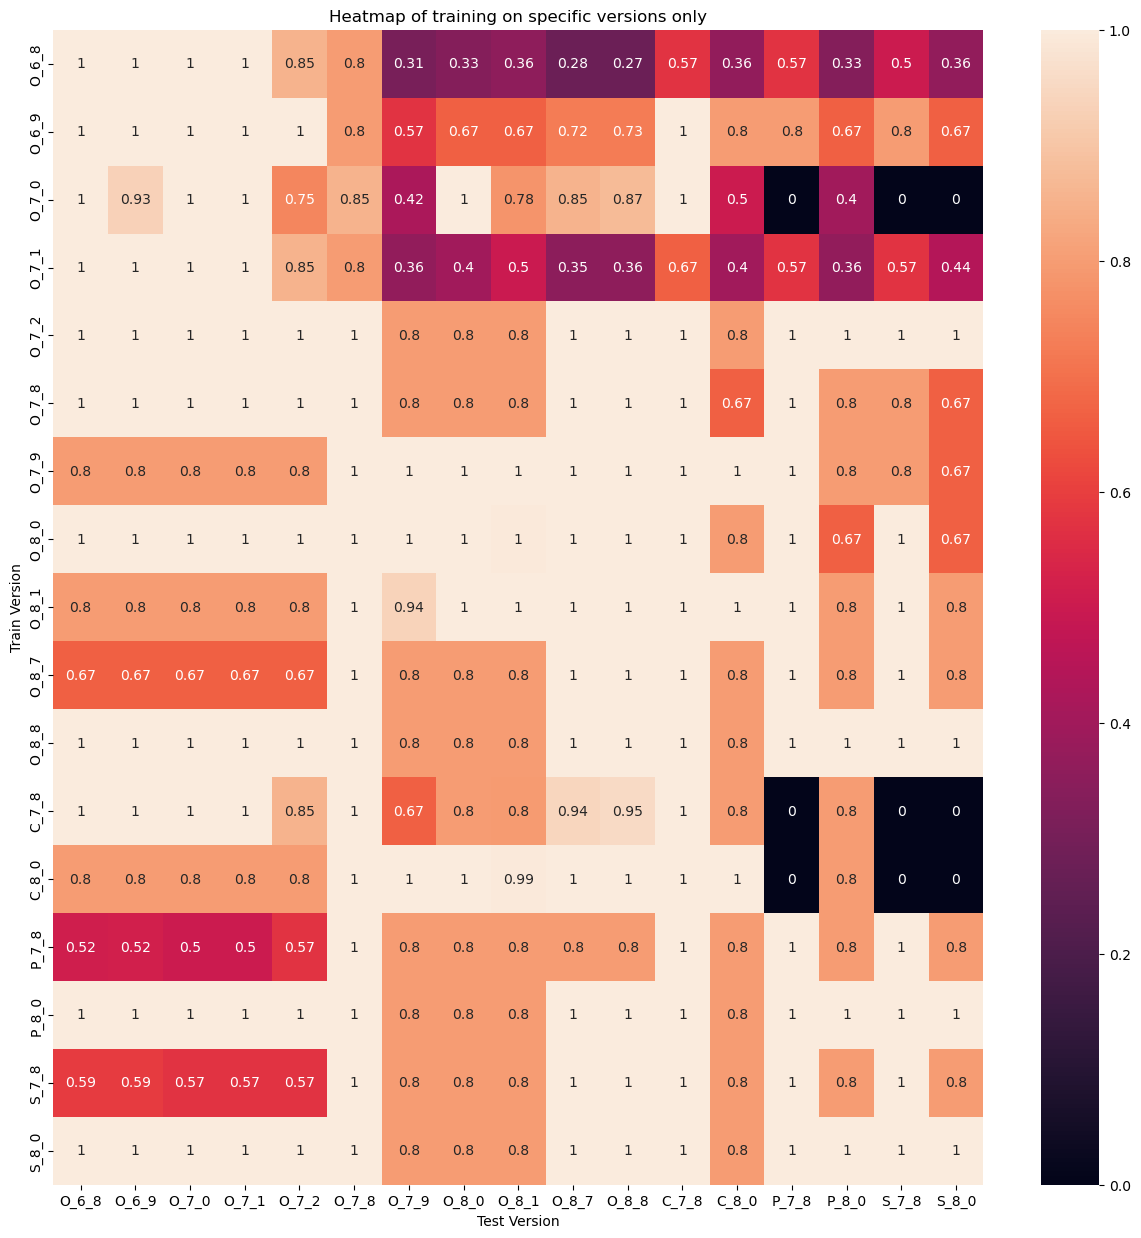

In [12]:
# Create heatmap and print it
# Format of X & Y labels are O_6_8 where O stands for OpenSSH, C for Client-side, P for Port-forwarding and S for SCP.
# The next two numbers seperated by '_' denotes which version of OpenSSH was used in that scenario
plt.figure(figsize=(15, 15))
sns.heatmap(f1_score_matrix[5:, 5:], annot=True, xticklabels=versions_test, yticklabels=versions_train)
plt.title("Heatmap of training on specific versions only")
plt.xlabel("Test Version")
plt.ylabel("Train Version")
plt.show()

In [13]:
sub_directories

['../Smart-VMI/data/new/OpenSSH/V_6_0_P1',
 '../Smart-VMI/data/new/OpenSSH/V_6_1_P1',
 '../Smart-VMI/data/new/OpenSSH/V_6_2_P1',
 '../Smart-VMI/data/new/OpenSSH/V_6_3_P1',
 '../Smart-VMI/data/new/OpenSSH/V_6_7_P1',
 '../Smart-VMI/data/new/OpenSSH/V_6_8_P1',
 '../Smart-VMI/data/new/OpenSSH/V_6_9_P1',
 '../Smart-VMI/data/new/OpenSSH/V_7_0_P1',
 '../Smart-VMI/data/new/OpenSSH/V_7_1_P1',
 '../Smart-VMI/data/new/OpenSSH/V_7_2_P1',
 '../Smart-VMI/data/new/OpenSSH/V_7_8_P1',
 '../Smart-VMI/data/new/OpenSSH/V_7_9_P1',
 '../Smart-VMI/data/new/OpenSSH/V_8_0_P1',
 '../Smart-VMI/data/new/OpenSSH/V_8_1_P1',
 '../Smart-VMI/data/new/OpenSSH/V_8_7_P1',
 '../Smart-VMI/data/new/OpenSSH/V_8_8_P1',
 '../Smart-VMI/data/new/client-side/V_7_8_P1',
 '../Smart-VMI/data/new/client-side/V_8_0_P1',
 '../Smart-VMI/data/new/port-forwarding/V_7_8_P1',
 '../Smart-VMI/data/new/port-forwarding/V_8_0_P1',
 '../Smart-VMI/data/new/scp/V_7_8_P1',
 '../Smart-VMI/data/new/scp/V_8_0_P1']

In [14]:
test_sub_directories

['../Smart-VMI/data/validation/OpenSSH/V_6_0_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_6_1_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_6_2_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_6_3_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_6_7_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_6_8_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_6_9_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_7_0_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_7_1_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_7_2_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_7_8_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_7_9_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_8_0_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_8_1_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_8_7_P1',
 '../Smart-VMI/data/validation/OpenSSH/V_8_8_P1',
 '../Smart-VMI/data/validation/client-side/V_7_8_P1',
 '../Smart-VMI/data/validation/client-side/V_8_0_P1',
 '../Smart-VMI/data/validation/port-forwarding/V_7_8_P1',
 '../Smart-VMI/data/validation/por

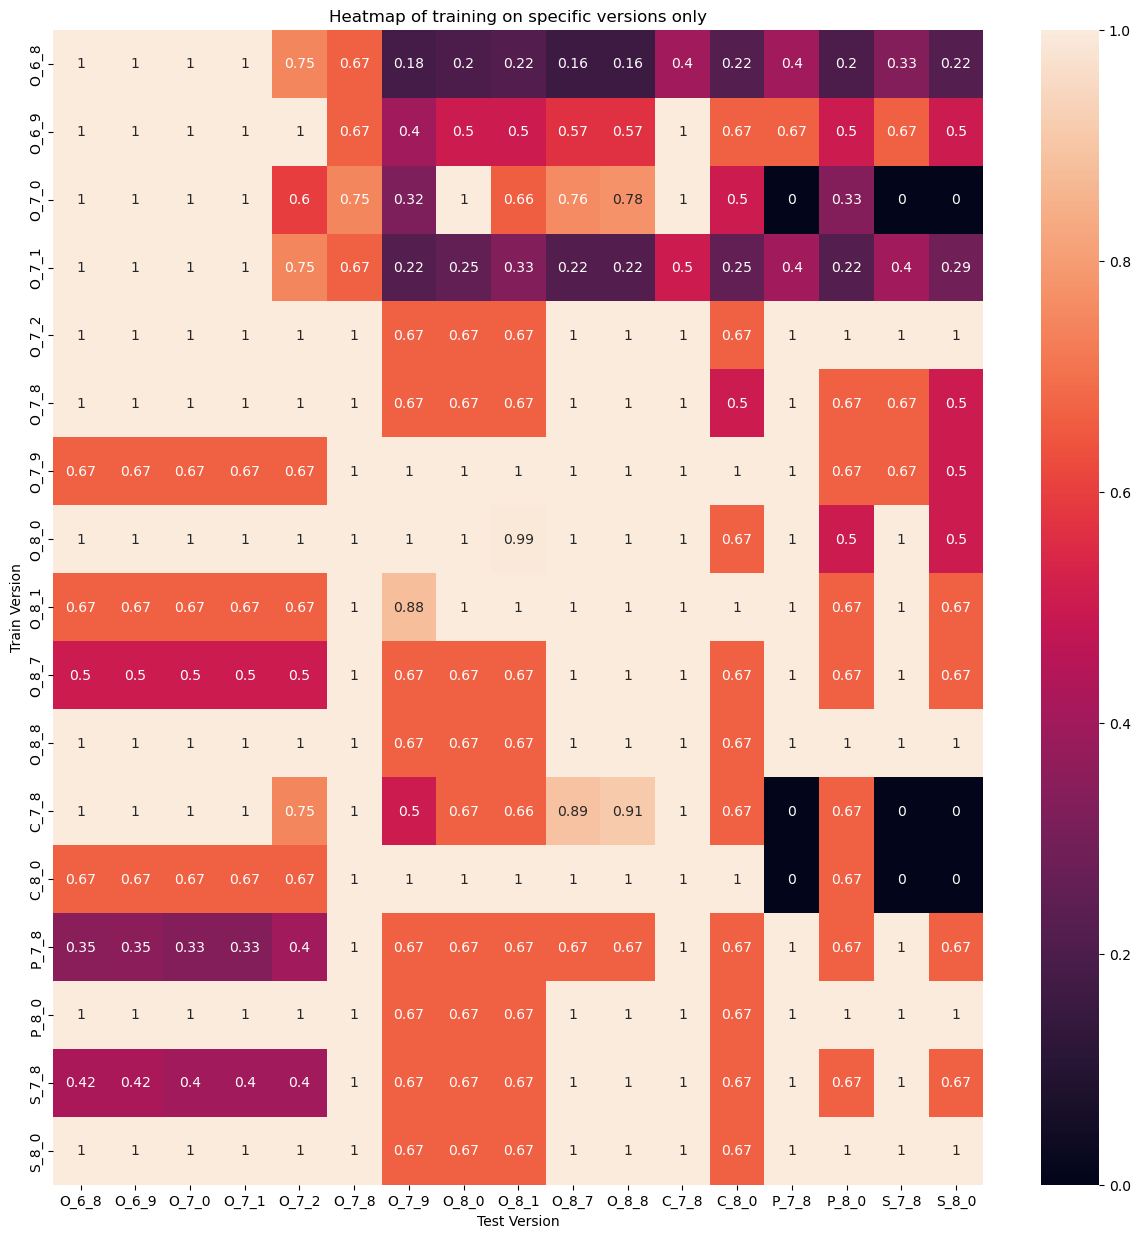

In [15]:
plt.figure(figsize=(15, 15))
sns.heatmap(precision_matrix[5:, 5:], annot=True, xticklabels=versions_test, yticklabels=versions_train)
plt.title("Heatmap of training on specific versions only")
plt.xlabel("Test Version")
plt.ylabel("Train Version")
plt.show()

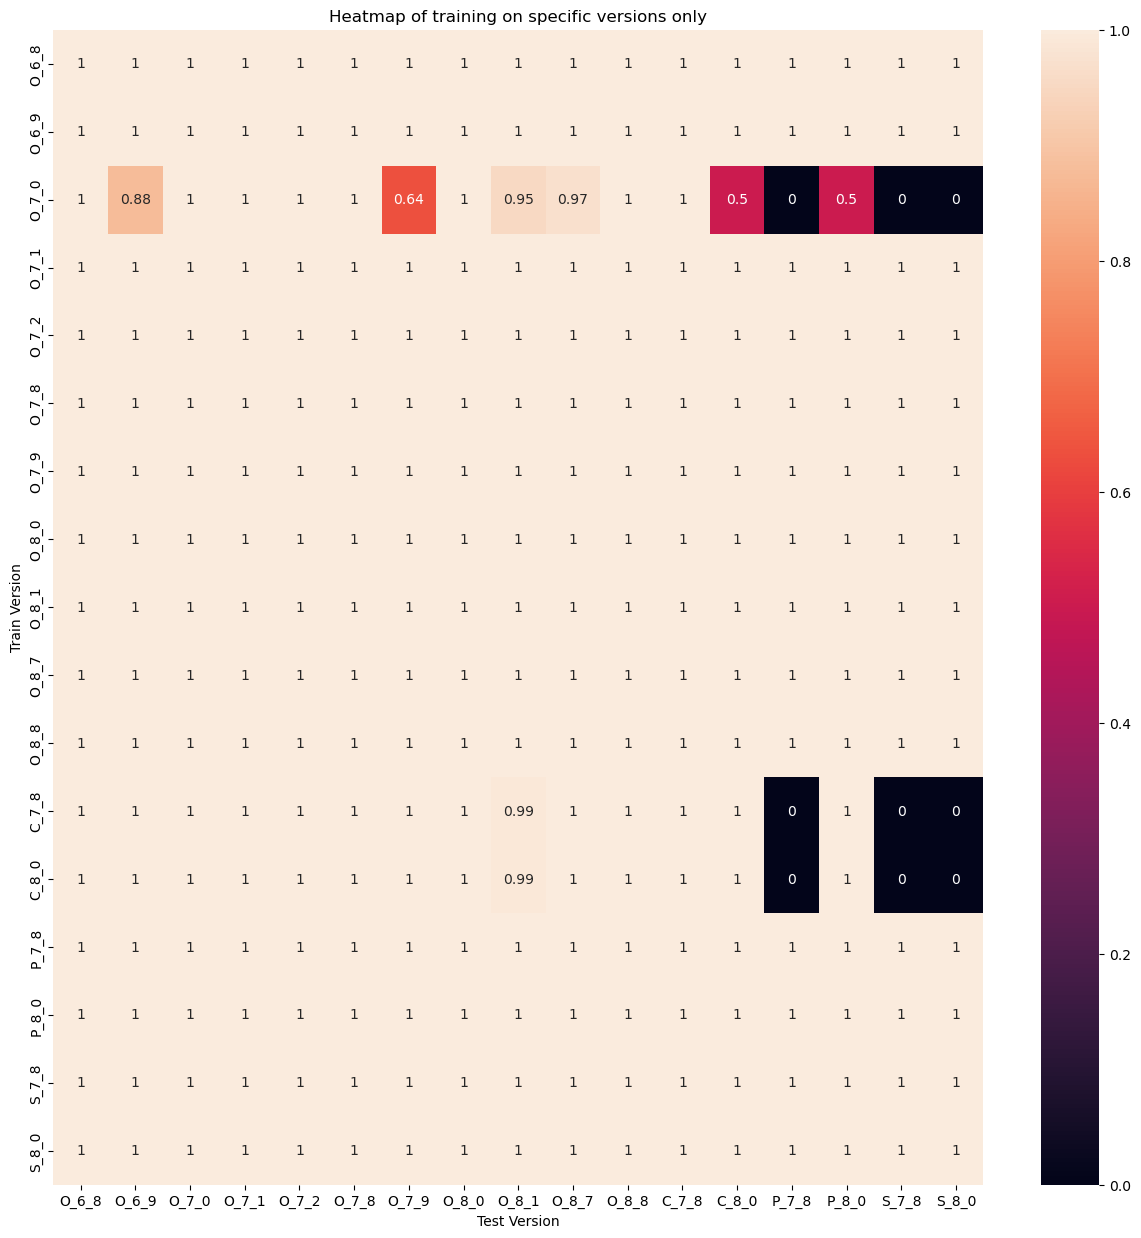

In [16]:
plt.figure(figsize=(15, 15))
sns.heatmap(recall_matrix[5:, 5:], annot=True, xticklabels=versions_test, yticklabels=versions_train)
plt.title("Heatmap of training on specific versions only")
plt.xlabel("Test Version")
plt.ylabel("Train Version")
plt.show()